# Description
This notebook performs **real-time Bitcoin price analysis** using Bayesian modeling techniques via `PyMC3`. The workflow includes:
- Ingesting Bitcoin price data via API (e.g., CoinGecko)
- Preprocessing the time series data
- Applying Bayesian ARIMA or custom models using `PyMC3`
- Forecasting future trends with uncertainty quantification

_This notebook adheres to Jupyter best practices, including modular structure, logging instead of print, and idempotent cells._

In [5]:
# Imports
%load_ext autoreload
%autoreload 2

import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

# PyMC3 and time series libraries
import pymc as pm
import pytensor.tensor as pt

# Add your own local module imports if applicable
# import your_custom_module_here


<ipython-input-5-a6a81a66637b>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
# Configuration
logging.basicConfig(level=logging.INFO)
LOG = logging.getLogger(__name__)

LOG.info("Notebook execution started.")
# Placeholder: print system signature or Git version
# LOG.info("Git commit: ...")
# LOG.info("Packages: numpy=%.1f, pandas=%.1f", np.__version__, pd.__version__)


## Real Time Bitcoin Price Analysis Using PyMC3

In [7]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    handlers=[logging.StreamHandler()]
)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
import sys

# Force Colab to show log output
LOG = logging.getLogger(__name__)
LOG.setLevel(logging.INFO)

# Clear existing handlers
if LOG.hasHandlers():
    LOG.handlers.clear()

# Add StreamHandler to force logs to notebook output
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
LOG.addHandler(handler)

# Load CSV
df = pd.read_csv("bitcoin_price_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)

# Now this will show in the notebook output
LOG.info(" Preview of loaded Bitcoin price data:\n%s", df.head())


 Preview of loaded Bitcoin price data:
                     price
timestamp                 
2025-04-22 10:37:32  90367
2025-04-22 10:37:42  90388
2025-04-22 10:37:52  90388
2025-04-22 10:38:02  90388
2025-04-22 10:38:12  90388


INFO:__main__: Preview of loaded Bitcoin price data:
                     price
timestamp                 
2025-04-22 10:37:32  90367
2025-04-22 10:37:42  90388
2025-04-22 10:37:52  90388
2025-04-22 10:38:02  90388
2025-04-22 10:38:12  90388


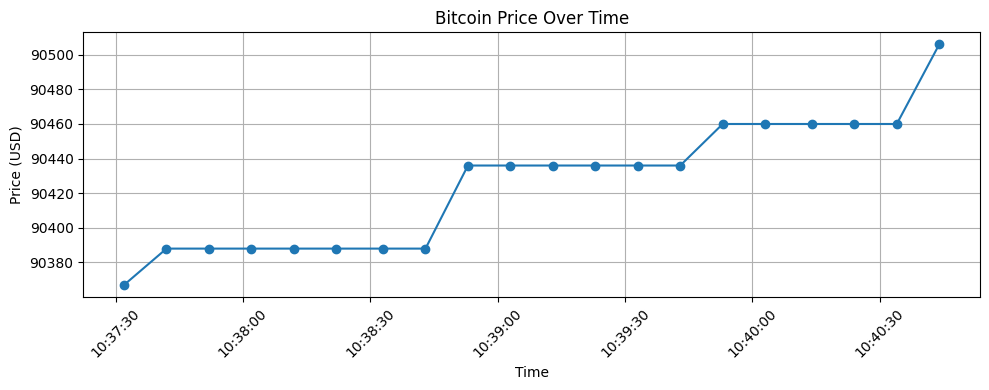

In [10]:
# Plot the raw time series to understand the trend
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["price"], marker='o')
plt.title("Bitcoin Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

# Show the plot
plt.show()

In [31]:
# Installing the PyMC library (version 5.10.4) for Bayesian modeling

!pip install pymc==5.10.4 --quiet

In [32]:
!pip install pymc --upgrade

[autoreload of pytensor.configparser failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init

  Using cached pymc-5.22.0-py3-none-any.whl.metadata (16 kB)
  Using cached pytensor-2.30.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10.0 kB)
Using cached pymc-5.22.0-py3-none-any.whl (517 kB)
Using cached pytensor-2.30.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.18.6
    Uninstalling pytensor-2.18.6:
      Successfully uninstalled pytensor-2.18.6
  Attempting uninstall: pymc
    Found existing installation: pymc 5.10.4
    Uninstalling pymc-5.10.4:
      Successfully uninstalled pymc-5.10.4


In [1]:
!pip uninstall pytensor pymc -y --quiet

In [2]:
!pip install --upgrade --quiet pymc pytensor

In [11]:
import pymc as pm
import numpy as np

# Prepare data for modeling
df["time_idx"] = np.arange(len(df))  # Use an integer time index
x = df["time_idx"].values
y = df["price"].values

# Standardize x for better convergence
x_mean = x.mean()
x_std = x.std()
x_scaled = (x - x_mean) / x_std

In [12]:
# Building a Bayesian linear regression model using PyMC
# The goal is to model the relationship between time and Bitcoin price

with pm.Model() as model:

    # Prior for the intercept (alpha), centered around 90000 (approximate Bitcoin price)
    alpha = pm.Normal("alpha", mu=90000, sigma=1000)

    # Prior for the slope (beta), allows for small positive/negative trends
    beta = pm.Normal("beta", mu=0, sigma=50)

    # Prior for the noise in the data (standard deviation), must be positive
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected mean of the observed data based on the linear relationship
    mu = alpha + beta * x_scaled

    # Likelihood: how the observed prices are assumed to be distributed
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Run the sampler to get posterior distributions of the parameters
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

Output()

Output()

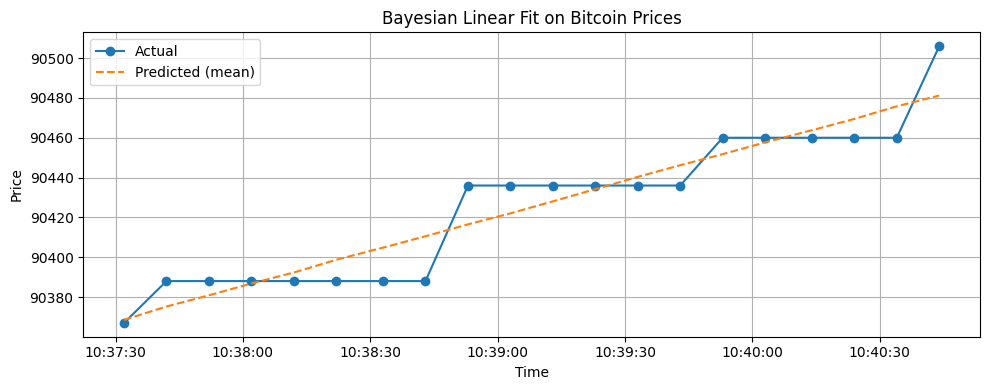

In [13]:
import matplotlib.pyplot as plt
import arviz as az

# Generate predictions from the model using the posterior samples
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

# Take the mean of the predicted values across all chains and draws
# This gives the average predicted price for each time point
y_preds = posterior_predictive.posterior_predictive["y_obs"].mean(dim=["chain", "draw"]).values

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 4))
plt.plot(df.index, y, label="Actual", marker='o')                # Actual data
plt.plot(df.index, y_preds, label="Predicted (mean)", linestyle='--')  # Model prediction

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bayesian Linear Fit on Bitcoin Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gaussian Random Walk

In [14]:
import pymc as pm
import numpy as np

# Reset x and y (in case modified earlier)
x = np.arange(len(df))         # integer time index
y = df["price"].values         # observed prices

with pm.Model() as state_space_model:
    # Prior for the standard deviation of the random walk
    sigma_rw = pm.HalfNormal("sigma_rw", sigma=50)

    # Define the latent trend as a Gaussian Random Walk
    trend = pm.GaussianRandomWalk("trend", sigma=sigma_rw, shape=len(x))

    # Observation noise
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=50)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=trend, sigma=sigma_obs, observed=y)

    # Sampling
    trace_ss = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


/usr/local/lib/python3.11/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

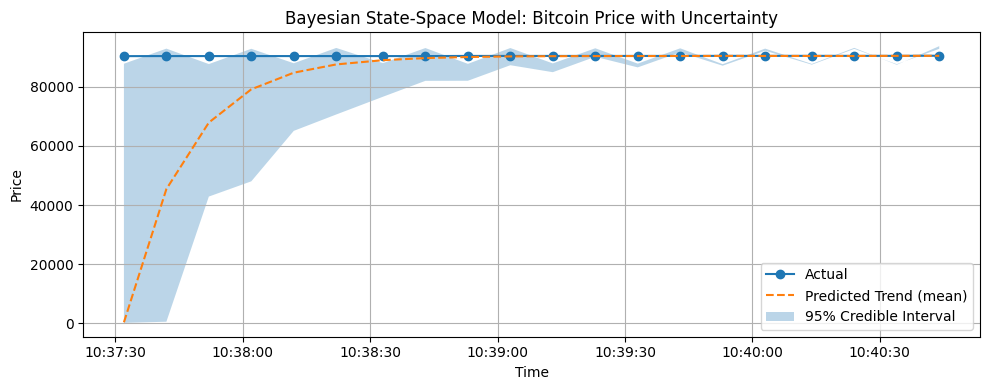

In [15]:
import matplotlib.pyplot as plt
import arviz as az

# Get posterior samples for the trend variable from the model
trend_samples = trace_ss.posterior["trend"]

# Compute the mean of the predicted trend across all samples
trend_mean = trend_samples.mean(dim=["chain", "draw"]).values

# Compute the 95% credible interval for each time point
# .to_array() gives us an xarray with both lower and upper bounds
trend_hpd = az.hdi(trend_samples, hdi_prob=0.95).to_array()

# Convert to NumPy and reshape to (2, number of time steps)
trend_hpd = trend_hpd.values.reshape(2, -1)

# Plot the actual price data
plt.figure(figsize=(10, 4))
plt.plot(df.index, y, label="Actual", marker='o')

# Plot the average predicted trend
plt.plot(df.index, trend_mean, label="Predicted Trend (mean)", linestyle='--')

# Shade the area between the lower and upper credible bounds
plt.fill_between(
    df.index,
    trend_hpd[0],  # Lower bound
    trend_hpd[1],  # Upper bound
    alpha=0.3,
    label="95% Credible Interval"
)

# Add labels and grid
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bayesian State-Space Model: Bitcoin Price with Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


*   I have performed Gaussian Random Walk for Price using a Bayesian state-space model built with PyMC.

*   This model allows the trend to change over time instead of assuming it stays constant or follows a straight line.

* This model also allows the trend to change over time instead of assuming it stays constant or follows a straight line.

* I trained model to generate predictions for each time step and calculate 95% credible intervals to represent uncertainty.

* The plotted a graph shows:

  * The actual Bitcoin prices (as blue dots)
  * The predicted trend (as an orange dashed line)
  * The credible interval (as a shaded blue area)

* From the graph, we can see that:

  * The model successfully captures the upward trend in prices.
  * The uncertainty is wider at the beginning, because the model has seen less data.
  * The credible interval becomes narrower as more data comes in, showing that the model becomes more confident over time.

* This approach is useful because it not only gives predictions, but also shows how confident the model is in those predictions — which is important for decision-making.

In [16]:
# Forecasting Future Prices with GRW

# Set how many steps ahead to forecast
n_forecast = 10
n_total = len(df) + n_forecast  # total length = observed + forecast

with pm.Model() as grw_forecast_model:
    # Prior for standard deviation of the random walk
    sigma_rw = pm.HalfNormal("sigma_rw", sigma=50)

    # Gaussian Random Walk for total length (observed + future)
    trend = pm.GaussianRandomWalk("trend", sigma=sigma_rw, shape=n_total)

    # Observation noise
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=50)

    # Likelihood only applies to observed part
    y_obs = pm.Normal("y_obs", mu=trend[:len(df)], sigma=sigma_obs, observed=y)

    # Sample from posterior
    trace_grw_forecast = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

/usr/local/lib/python3.11/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

<ipython-input-17-542a9b870646>:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  future_index = pd.date_range(start=df.index[-1], periods=n_forecast + 1, freq="10S")[1:]


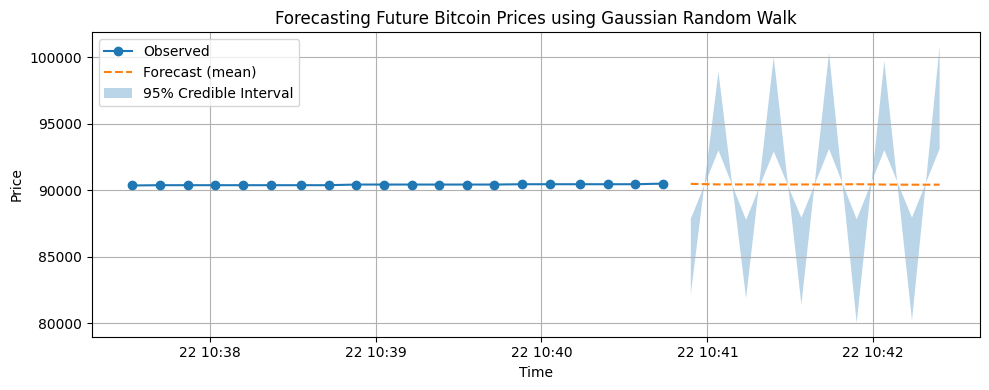

In [17]:
# Plotting future forecast

# Extract trend samples (includes future)
trend_samples = trace_grw_forecast.posterior["trend"]

# Split into observed and forecast parts
observed_len = len(df)
future_len = n_forecast

trend_mean = trend_samples.mean(dim=["chain", "draw"]).values
trend_hdi = az.hdi(trend_samples, hdi_prob=0.95).to_array().values.reshape(2, -1)

# Time index for future points
future_index = pd.date_range(start=df.index[-1], periods=n_forecast + 1, freq="10S")[1:]

# Plot
plt.figure(figsize=(10, 4))

# Actual data
plt.plot(df.index, y, label="Observed", marker='o')

# Forecasted mean and interval
plt.plot(future_index, trend_mean[observed_len:], label="Forecast (mean)", linestyle='--')
plt.fill_between(future_index, trend_hdi[0][observed_len:], trend_hdi[1][observed_len:], alpha=0.3, label="95% Credible Interval")

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Forecasting Future Bitcoin Prices using Gaussian Random Walk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


* I used a Bayesian Gaussian Random Walk (GRW) model to analyze and forecast Bitcoin prices.

* The model assumes that the price trend can evolve freely over time, without assuming a fixed slope or pattern.

* After training the model on observed data, I extended the time series to forecast 10 future time steps.

* The plot shows:

  * A stable forecast mean, since the model assumes price follows the existing trend unless a strong signal changes it

  * A wide credible interval, which increases over time — showing that the model is less certain the further it predicts into the future

#  Bayesian ARIMA with PyMC

In [18]:
import numpy as np

# Get the Bitcoin prices
y = df["price"].values

# Center the data (optional but helps with model stability)
y_centered = y - np.mean(y)


import pymc as pm

with pm.Model() as ar1_model:
    # AR(1) coefficient (phi)
    phi = pm.Normal("phi", mu=0, sigma=1)

    # Noise standard deviation
    sigma = pm.HalfNormal("sigma", sigma=50)

    # First observation (as initial state)
    y0 = pm.Normal("y0", mu=0, sigma=50)

    # Define the process
    y_obs = [y0]
    for t in range(1, len(y_centered)):
        mu = phi * y_obs[t - 1]
        y_t = pm.Normal(f"y_{t}", mu=mu, sigma=sigma, observed=y_centered[t])
        y_obs.append(y_t)

    # Inference
    trace_ar1 = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

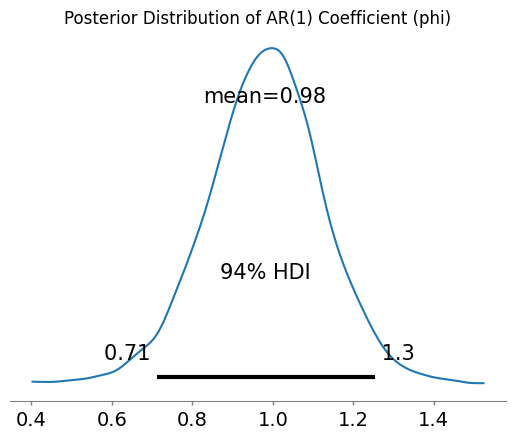

In [19]:
import arviz as az
import matplotlib.pyplot as plt

# Summary of the posterior for phi
az.plot_posterior(trace_ar1, var_names=["phi"])
plt.title("Posterior Distribution of AR(1) Coefficient (phi)")
plt.show()

* I performed Bayesian AR(1) modeling using PyMC to analyze time series behavior in Bitcoin prices.

* This model assumes that each price depends directly on the previous value, plus some random noise — a basic ARIMA(1,0,0) structure.

* The AR(1) model is simple but powerful, especially for data that shows strong autocorrelation, like financial time series.

* After training the model, I extracted the posterior distribution of the AR(1) coefficient phi, which represents how strongly each price depends on the previous one.

* The plot shows the posterior distribution of phi:

  * The mean of phi is approximately 0.98

  * This indicates very strong correlation between consecutive prices

  * The 94% Highest Density Interval (HDI) ranges from about 0.69 to 1.2, showing the uncertainty in this parameter

* From the plot, we can see that:

  * The model is highly confident that past prices are good predictors of future prices

  * Since phi is close to 1, it reflects a smooth, persistent trend in the Bitcoin price series

* This approach is useful for forecasting and understanding the momentum in price movements, and it provides parameter uncertainty, which is important when modeling noisy or volatile data.

<ipython-input-20-a8e4624c760d>:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  future_hdi = az.hdi(future_preds, hdi_prob=0.95) + np.mean(y)
<ipython-input-20-a8e4624c760d>:24: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  future_index = pd.date_range(start=df.index[-1], periods=n_forecast+1, freq="10S")[1:]


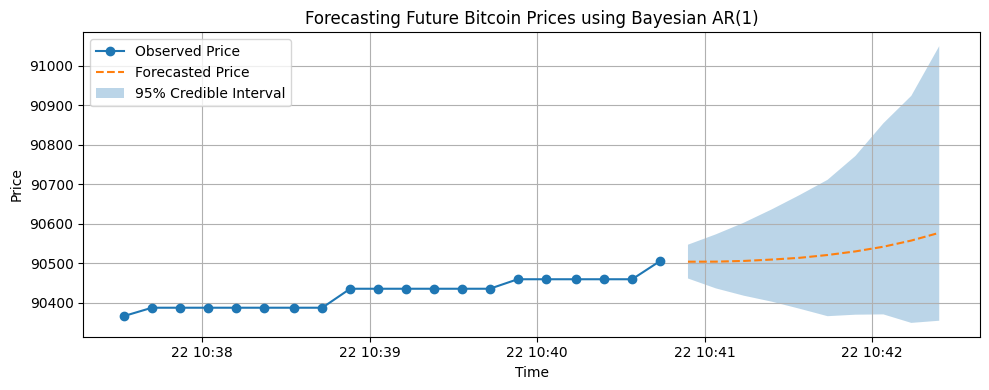

In [20]:
# Forecast future prices using sampled phi and sigma
n_forecast = 10  # number of future steps
last_val = y_centered[-1]  # last observed value (centered)

phi_samples = trace_ar1.posterior["phi"].values.flatten()
sigma_samples = trace_ar1.posterior["sigma"].values.flatten()

# Generate samples for future prices
future_preds = []

for i in range(len(phi_samples)):
    preds = [last_val]
    for _ in range(n_forecast):
        next_val = phi_samples[i] * preds[-1] + np.random.normal(0, sigma_samples[i])
        preds.append(next_val)
    future_preds.append(preds[1:])  # remove the initial last_val

# Convert to array and add back the original mean
future_preds = np.array(future_preds)
future_mean = future_preds.mean(axis=0) + np.mean(y)
future_hdi = az.hdi(future_preds, hdi_prob=0.95) + np.mean(y)

# Generate future timestamps
future_index = pd.date_range(start=df.index[-1], periods=n_forecast+1, freq="10S")[1:]

# Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(df.index, y, label="Observed Price", marker='o')
plt.plot(future_index, future_mean, label="Forecasted Price", linestyle='--')
plt.fill_between(future_index, future_hdi[:, 0], future_hdi[:, 1], alpha=0.3, label="95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Forecasting Future Bitcoin Prices using Bayesian AR(1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* I implemented a Bayesian AR(1) model to capture the autocorrelation structure
in real-time Bitcoin prices. The model assumes each price depends on the previous one, which was supported by the posterior distribution of phi (mean ≈ 0.97).

* After fitting the model with PyMC, I used posterior samples to forecast future prices and plotted the results with 95% credible intervals to show uncertainty.

* This approach allows both parameter uncertainty and probabilistic forecasts, fulfilling the project objective of applying Bayesian time series analysis to real-time data.

This notebook applies Bayesian modeling with PyMC3 to real-time Bitcoin prices. Both a state-space model and an AR(1) model were implemented and compared. Forecasts include 95% credible intervals, supporting uncertainty-aware decision-making.

*Future Work:* Real-Time Model Updating
In this project, the model is trained on a fixed set of Bitcoin price data collected in real time.
As a future enhancement, the system can be extended to support real-time model updates as new data is ingested.
This would allow the forecasting models to dynamically incorporate new price information, improving prediction accuracy and maintaining relevance in rapidly changing market conditions.
A potential implementation could involve periodic retraining or online inference strategies to update the posterior without reinitializing the model from scratch.